In [1]:
import numpy as np
import nibabel as nib
from scipy.signal import butter, filtfilt, hilbert, freqz
import matplotlib.pyplot as plt
import h5py
%matplotlib inline
subjects = np.loadtxt('../100unrelatedsubjectsIDs.txt', dtype='str')
p = 3
K = 2
T = 1200
num_subs = 10

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="bandpass")
    return b, a

# Apply Filter
# Changed by Anders to be correct range (from 0.01-0.1 to 0.009-0.08)
def butter_bandpass_filter(data, lowcut=0.009, highcut=0.08, fs=1 / 0.720, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

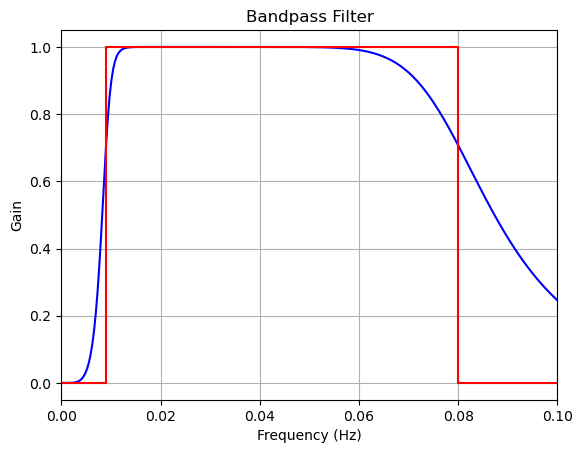

In [3]:
# b,a = butter_bandpass(0.009, 0.08, 1 / 0.720, order=5)
b,a = butter(5,Wn=[0.009,0.08],btype='bandpass',fs=1/0.720)
w, h = freqz(b, a, worN=2000, fs=1 / 0.720)
plt.plot(w, abs(h), 'b')
plt.plot([0, 0.009, 0.009, 0.08, 0.08, 0.5], [0, 0, 1, 1, 0, 0], 'r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Bandpass Filter')
plt.xlim(0, 0.1)
plt.grid(True)
plt.show()

In [4]:
atlas = nib.load('../data/external/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S1.dlabel.nii')
atlas_data = atlas.get_fdata()
atlas_data = np.round(atlas_data)
atlas_data = atlas_data.astype(int)[0]
filtered_data_all = []

for sub in subjects[:num_subs]:
    img = nib.load('../data/raw/'+sub+'/fMRI/rfMRI_REST1_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii')
    data = img.get_fdata()
    data = data - np.mean(data, axis=0)

    GS = np.mean(data[:,:59412], axis=1)
    data = data - GS[:,None]*(data.T@GS).T/(GS.T@GS)
    
            # GS = mean(data(:,1:59412),2);
            # data = data-GS.*(data'*GS)'/(GS'*GS);
    # parcellate data in atlas
    parcellated_data = np.zeros((data.shape[0], atlas_data.max()))
    for i in range(1, atlas_data.max()+1):
        parcellated_data[:,i-1] = np.mean(data[:,atlas_data == i], axis=1)
    # filter data
    filtered_data = np.zeros((T,p))
    for i in range(p):
        filtered_data[:,i] = butter_bandpass_filter(parcellated_data[:,i])
    filtered_data_all.append(filtered_data)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(-0.1, 0.1)

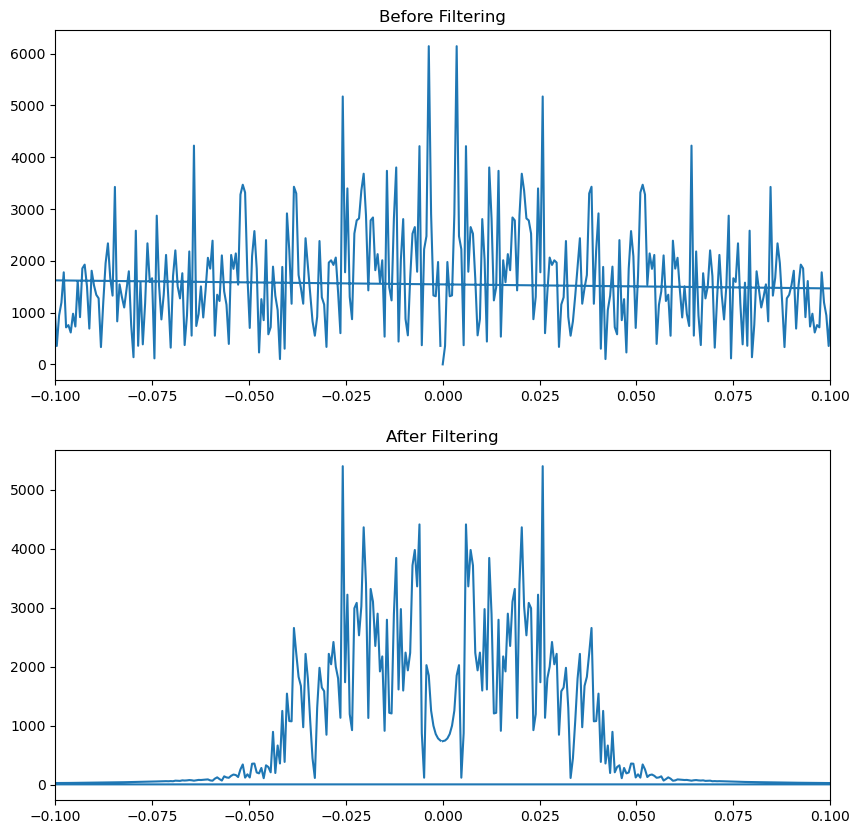

In [5]:
plt.figure(figsize=(10,10))
# plot the fft amplitude information before and after filtering
f = np.fft.fftfreq(T, 1/0.720)
plt.subplot(2,1,1)
plt.plot(f,np.abs(np.fft.fft(parcellated_data[:,0])))
plt.title('Before Filtering')
plt.xlim([-0.1,0.1])
plt.subplot(2,1,2)
plt.plot(f,np.abs(np.fft.fft(filtered_data[:,0])))
plt.title('After Filtering')
plt.xlim([-0.1,0.1])


Set phase information equal to template phases, maintain existing amplitude information

In [6]:
num_repeats = 1 #repeats of clustering pattern state1..state2.. etc

times = np.linspace(0, 1200, K*num_repeats+1, dtype=int)
num_samples = times[1]-times[0]
num_add = num_samples//10
TR = 0.720
f = np.fft.fftfreq(num_samples+num_add*2, 1/TR)
# find indices of frequencies above or equal to 0.008Hz and below or equal to 0.09Hz
positive_frequency_content_indices = np.where((f>=0.009) & (f<=0.08))[0]
negative_frequency_content_indices = np.where((f<=-0.009) & (f>=-0.08))[0]
num_phases = len(positive_frequency_content_indices)

nodes = [0, 1]
nodes = np.tile(nodes, num_repeats)
specs = []
for window in range(K*num_repeats):
    ref = filtered_data_all[0][times[window]:times[window+1],nodes[window]]
    if num_add>0:
        ref = np.concatenate((2*ref[0]-np.flip(ref[1:num_add+1]),ref,2*ref[-1]-np.flip(ref[-num_add-1:-1])))
    specs.append(np.fft.fft(ref))

phase_reset_data_all = []
phase_shifts = np.random.rand(p)*2*np.pi-np.pi #within-cluster phase shifts equal across subjects
for sub in range(num_subs):
    newdata = np.zeros((T,p))
    for window in range(K*num_repeats):
        for i in range(p):
            signal = filtered_data_all[sub][times[window]:times[window+1],i]
            if num_add>0:
                signal = np.concatenate((2*signal[0]-np.flip(signal[1:num_add+1]),signal,2*signal[-1]-np.flip(signal[-num_add-1:-1])))
            signal_spec = np.fft.fft(signal)
            
            if (window==0 and i in [0,1]) or (window==1 and i in [1,2]):
                phases = np.full(num_phases,phase_shifts[i])
                # new_phases = np.angle(specs[window])
                new_phases = np.angle(signal_spec)
                new_phases[positive_frequency_content_indices] = phases
                new_phases[negative_frequency_content_indices] = -phases[::-1]
                # tmp = np.abs(signal_spec) * np.exp(1j*new_phases)
                tmp = np.abs(specs[window]) * np.exp(1j*new_phases)
            else:
                phases = np.random.rand(num_phases)*2*np.pi-np.pi
                new_phases = np.angle(signal_spec)
                new_phases[positive_frequency_content_indices] = phases
                new_phases[negative_frequency_content_indices] = -phases[::-1]
                # tmp = np.abs(signal_spec) * np.exp(1j*new_phases)
                tmp = np.abs(specs[window]) * np.exp(1j*new_phases)

            # imaginary part is negligible
            new_signal = np.fft.ifft(tmp).real
            if num_add>0:
                new_signal = new_signal[num_add:-num_add]
            newdata[times[window]:times[window+1],i] = new_signal

    phase_reset_data_all.append(newdata)

In [10]:
phase_reset_data = np.concatenate(phase_reset_data_all, axis=0)
with h5py.File('../data/synthetic/phase_controlled_3data.h5', 'w') as f:
    f.create_dataset("X", data=phase_reset_data)

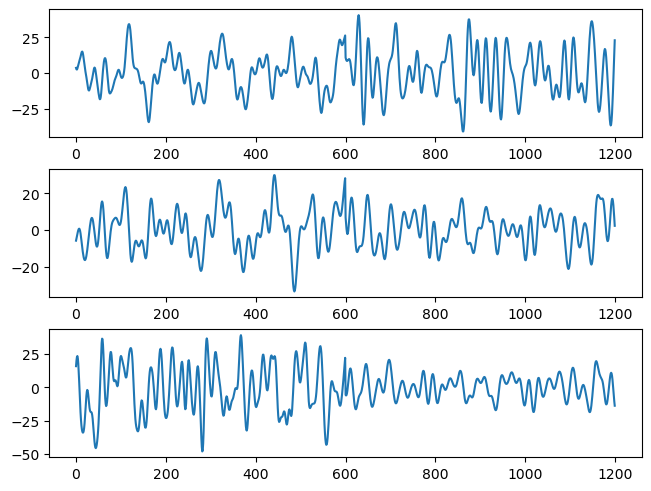

In [11]:
fig,axs = plt.subplots(3,1,layout='constrained')
axs[0].plot(phase_reset_data_all[0][:,0]);
axs[1].plot(phase_reset_data_all[0][:,1]);
axs[2].plot(phase_reset_data_all[0][:,2]);

Calculate LEiDA

In [12]:
U_all = []
S_all = []
phase_coh_maps = np.zeros((num_subs*T,p,p))
for sub in range(num_subs):
    phases = np.zeros((phase_reset_data_all[sub].shape[0], p))
    for i in range(p):
        phases[:,i] = np.angle(hilbert(phase_reset_data_all[sub][:,i]))
    U_all_sub = np.zeros((T,p,2))
    S_all_sub = np.zeros((T,2))
    for t in range(T):
        c = np.cos(phases[t])
        s = np.sin(phases[t])
        phase_coh_maps[sub*T+t] = np.outer(c,c)+np.outer(s,s)
        U,S,_ = np.linalg.svd(np.c_[c,s], full_matrices=False)
        U_all_sub[t] = U
        S_all_sub[t] = S
    U_all.append(U_all_sub)
    S_all.append(S_all_sub)
U_tmp = np.concatenate(U_all, axis=0)

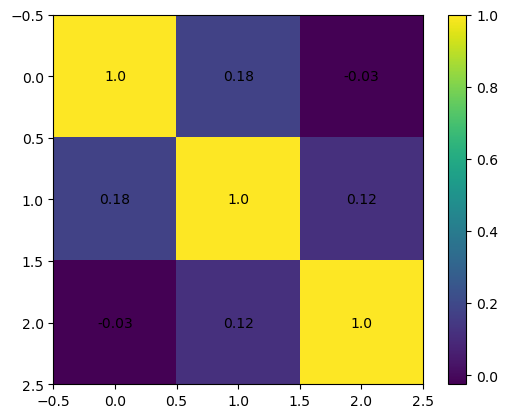

In [24]:
plt.imshow(np.mean(phase_coh_maps[:600], axis=0))
#overlay the actual numbers
for i in range(p):
    for j in range(p):
        plt.text(i,j,round(np.mean(phase_coh_maps[:600,i,j]),2),ha='center',va='center')
plt.colorbar()

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:20: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:20: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_810999/3861262106.py:16: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_title('$\lambda_1=$'+str(l[order[0]]))
/tmp/ipykernel_810999/3861262106.py:20: SyntaxWarning: invalid escape sequence '\l'
  axs[2].set_title('$\lambda_2=$'+str(l[order[1]]))


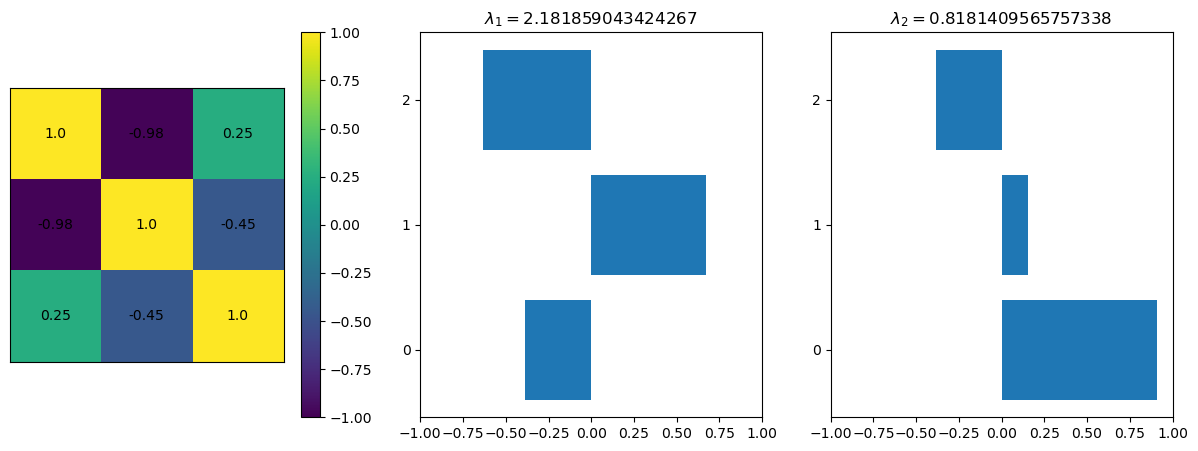

In [69]:
idx=np.random.randint(0,num_subs*T)
fig,axs = plt.subplots(1,3,figsize=(15,5))
im = axs[0].imshow(phase_coh_maps[idx],vmin=-1,vmax=1)
axs[0].set_xticks([])
axs[0].set_yticks([])
#colorbar on axis
cbar = plt.colorbar(im,ax=axs[0])
for i in range(p):
    for j in range(p):
        axs[0].text(i,j,round(phase_coh_maps[idx,i,j],2),ha='center',va='center')

l,u = np.linalg.eig(phase_coh_maps[idx])
order = np.argsort(l)[::-1]

axs[1].barh(np.array([0,1,2]),np.flip(u[:,order[0]]))
axs[1].set_title('$\lambda_1=$'+str(l[order[0]]))
axs[1].set_xlim([-1,1])
axs[1].set_yticks([0,1,2])
axs[2].barh(np.array([0,1,2]),np.flip(u[:,order[1]]))
axs[2].set_title('$\lambda_2=$'+str(l[order[1]]))
axs[2].set_xlim([-1,1])
axs[2].set_yticks([0,1,2])

In [27]:
a1,a2 = np.linalg.eigh(np.mean(phase_coh_maps[0], axis=0))
print(a1)
print(a2)

[-3.31594713e-17  7.49696988e-01  2.25030301e+00]
[[-0.30526162  0.83274208 -0.46190473]
 [ 0.59786539  0.54514084  0.58768907]
 [ 0.74119655 -0.09675793 -0.66427824]]


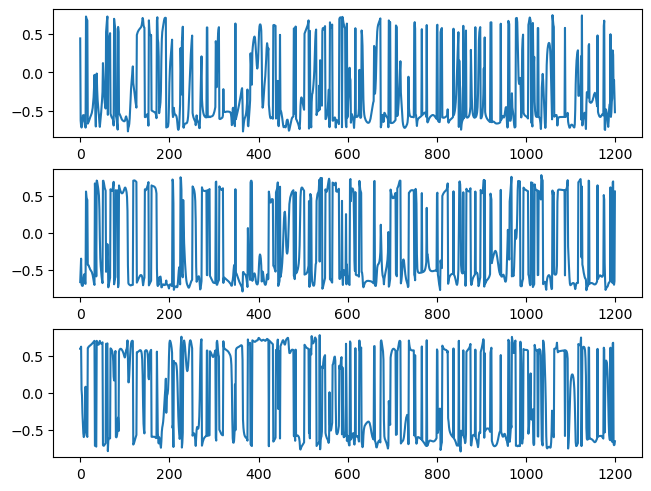

In [15]:
fig,axs = plt.subplots(3,1,layout='constrained')
axs[0].plot(U_all[1][:,0,0]);
axs[1].plot(U_all[1][:,1,0]);
axs[2].plot(U_all[1][:,2,0]);

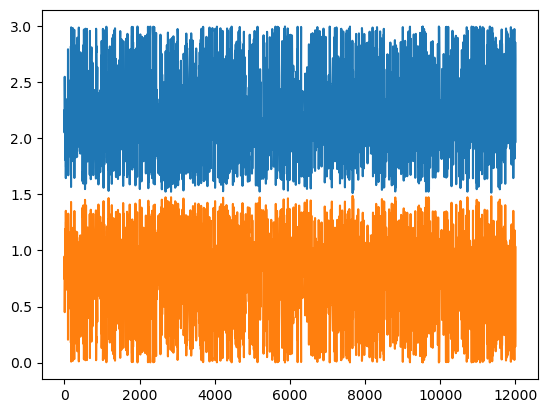

In [16]:
S_tmp = np.concatenate(S_all, axis=0)
plt.plot(S_tmp[0:]**2);
# plt.xlim([0,242])

<BarContainer object of 3 artists>

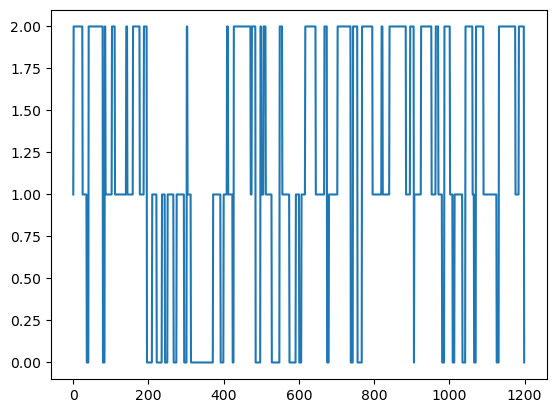

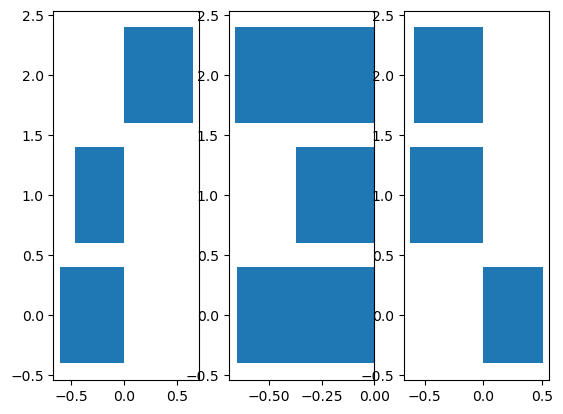

In [17]:
from src.DMM_EM.riemannian_clustering import diametrical_clustering, grassmannian_clustering_gruber2006
C_DC,X_part_DC,_ = diametrical_clustering(U_tmp[:,:,0],K=3)
plt.figure()
plt.plot(X_part_DC[:1200])
plt.figure()
plt.subplot(1,3,1)
plt.barh(range(p),C_DC[:,0])
plt.subplot(1,3,2)
plt.barh(range(p),C_DC[:,1])
plt.subplot(1,3,3)
plt.barh(range(p),C_DC[:,2])

<BarContainer object of 3 artists>

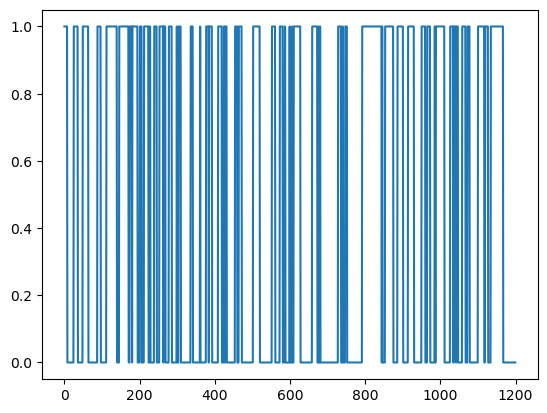

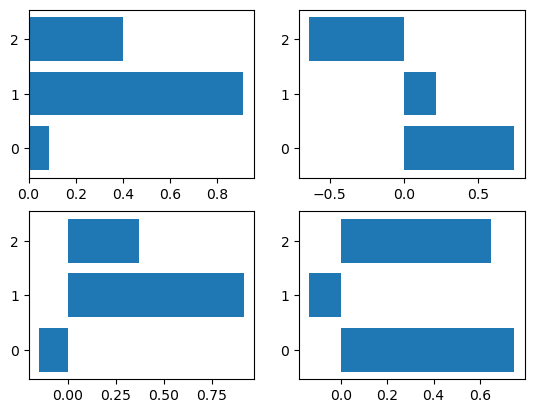

In [18]:
C_GC,X_part_GC,_ = grassmannian_clustering_gruber2006(U_tmp,K=K)
plt.figure()
plt.plot(X_part_GC[:1200])
plt.figure()
plt.subplot(2,2,1)
plt.barh(range(p),C_GC[0,:,0])
plt.subplot(2,2,2)
plt.barh(range(p),C_GC[0,:,1])
plt.subplot(2,2,3)
plt.barh(range(p),C_GC[1,:,0])
plt.subplot(2,2,4)
plt.barh(range(p),C_GC[1,:,1])

In [19]:
# use h5py to save this data (U_all)
with h5py.File('../data/synthetic/phase_controlled_3data_eida.h5', 'w') as f:
    f.create_dataset("U", data=U_tmp)

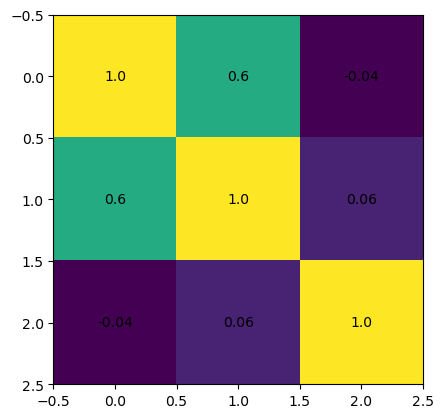

In [20]:
a = np.random.random()*0.2-0.1
b = np.random.random()*0.2-0.1
matrix = np.array([[1,0.6,a],[0.6,1,b],[a,b,1]])
#show the matrix with numbers
plt.imshow(matrix)
for i in range(3):
    for j in range(3):
        plt.text(i,j,round(matrix[i,j],2),ha='center',va='center')
        

Text(0.5, 1.0, '1.6003995000188878')

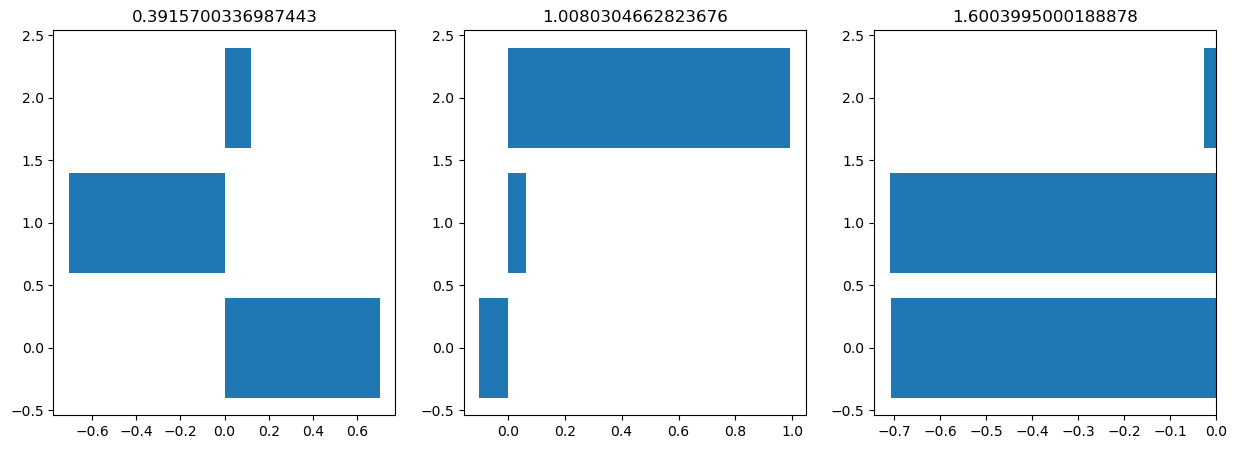

In [21]:
# find the eigenvectors and eigenvalues
a1,a2 = np.linalg.eigh(matrix)
# show the eigenvectors as barh plot with corresponding eigenvalue as title
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.barh(range(3),a2[:,0])
plt.title(str(a1[0]))
plt.subplot(1,3,2)
plt.barh(range(3),a2[:,1])
plt.title(str(a1[1]))
plt.subplot(1,3,3)
plt.barh(range(3),a2[:,2])
plt.title(str(a1[2]))
